<div style="float:left;font-size:20px;">
    <h1>Interpolation ND Debugging</h1>
</div><div style="float:right;"><img src="../../assets/banner.jpg"></div>

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, r"R:\Projects\MultivariateInterpolation")
sys.path.insert(0, r"R:\Projects\catana")
from catana.core.timer import Timer
from baryrat import aaa
# Polynomial interpolation - Example
Z = np.linspace(0.0, 1.0, 100)
X = np.linspace(0.0, 1.0, 100)
F = np.exp(Z) * np.sin(2*np.pi*X)
r = aaa((X,Z), F, mmax=10)

In [3]:
r(np.array((0.1, 0.1))) - np.exp(0.1) * np.sin(2*np.pi*0.1)

array([-5.68434189e-14, -5.68434189e-14])

In [4]:
from scipy.interpolate import (
    LinearNDInterpolator, RectBivariateSpline, BarycentricInterpolator,
    RegularGridInterpolator)

In [5]:
def gridpoints(n, a=-1, b=1):
    """Returns Chebyshev nodes of specified dimensions.
    
    int n: Number of Chebyshev nodes
    float a: Interval minimum
    float b: Interval maximum
    
    Further reading: https://en.wikipedia.org/wiki/Chebyshev_nodes
    """
    x_i = 0.5*(b + a) + 0.5*(b - a) * np.cos( np.pi * (np.arange(1, n + 1) - 0.5)/n)
    return np.array(sorted(x_i))

In [6]:
def f_2d(x, y=0):
    return np.cos(0.5 * np.pi * x)
    #return np.cos(6*pi*x)
    #return 1/(1  + 25*x*x)

## Demonstrate 2D interpolation

In [7]:
def evaluate_interp_2d(x_eval, y_eval, f_true, f_interp):
    z_true = np.array([f_true(x, y) for y in y_eval for x in x_eval ])
    #xv, yv = np.meshgrid(x_eval, y_eval, sparse=False, indexing='ij')
    z_interp = np.array([f_interp((x, y)) for y in y_eval for x in x_eval ])
    z_error = np.abs(z_interp - z_true)
    return z_true.reshape(len(y_eval), -1), z_interp.reshape(len(y_eval), -1), z_error.reshape(len(y_eval), -1)

In [8]:
def evaluate_interp_2d_poly(x_eval, y_eval, f_true, f_interp):
    z_true = np.array([f_true(x) for x in x_eval ])
    #xv, yv = np.meshgrid(x_eval, y_eval, sparse=False, indexing='ij')
    z_interp = f_interp(x_eval)
    z_error = np.abs(z_interp - z_true)
    return z_true.reshape(-1), z_interp.reshape( -1), z_error.reshape( -1)

In [9]:
# Train interpolator
Ninterp = 13
Ninterpy = 3
xinterp = gridpoints(Ninterp) #np.linspace(-1, 1, Ninterp)
yinterp = gridpoints(Ninterpy) #np.linspace(-1, 1, Ninterp)

values = np.zeros((Ninterp, Ninterpy))
points = np.zeros((Ninterp, Ninterpy, 2))
for i, x in enumerate(xinterp):
    for j, y in enumerate(yinterp):
        values[i][j] = f_2d(x, y)
        points[i][j] = (x, y)

f_2d_interp = RegularGridInterpolator((xinterp, yinterp), values)

In [10]:
f_2d_interp_poly = aaa(xinterp, f_2d, mmax=10)

In [11]:
# Evaluation points
Neval = 200
x_eval = np.linspace(-0.98, 0.98, Neval)
y_eval = np.array([-0.1, 0, 0.1])
z_true, z_interp, z_error = evaluate_interp_2d(x_eval, y_eval, f_2d, f_2d_interp)
z_true_poly, z_interp_poly, z_error_poly = evaluate_interp_2d_poly(x_eval, y_eval, f_2d, f_2d_interp_poly)
#z_truec, z_interpc, z_errorc = evaluate_interp_2d_cubic(x_eval, y_eval, f_2d, f_2d_interp_cubic)

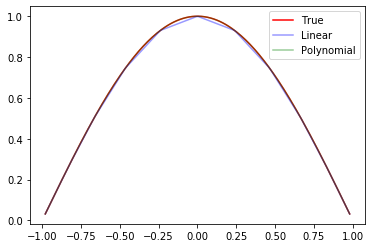

In [12]:
#plt.scatter(x_interp, value, color='black', s=4)
plt.plot(x_eval, z_true[0], color='r', label='True')
plt.plot(x_eval, z_interp[0], color='b', alpha=0.4, label='Linear')
plt.plot(x_eval, z_interp_poly, color='g', alpha=0.4, label='Polynomial')
plt.legend();

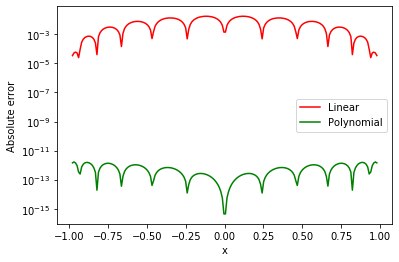

In [13]:
plt.plot(x_eval, z_error[1], color='r', label='Linear')
plt.plot(x_eval, z_error_poly, color='g', label='Polynomial')

plt.xlabel('x')
plt.ylabel('Absolute error')
plt.yscale('log')
plt.legend();

In [14]:
# Generate train set
n_points = np.arange(3, 50) # Range of points to evaluate accuracy over

errors_lin_cheby, errors_cubic_cheby, errors_poly_cheby = [], [], []

for n in n_points:
    xinterp = gridpoints(n)
    yinterp = gridpoints(3)
    values = np.zeros((n, 3))
    for i, x in enumerate(xinterp):
        for j, y in enumerate(yinterp):
            values[i][j] = f_2d(x, y)

    f_2d_interp = RegularGridInterpolator((xinterp, yinterp), values)
    f_2d_interp_poly = aaa(xinterp, f_2d, mmax=10)

    # Evaluate performance
    x_eval = np.linspace(np.min(xinterp), np.max(xinterp), 50)
    y_eval = np.linspace(np.min(yinterp), np.max(yinterp), 3)
    
    _, _, y_error_lin_cheby = evaluate_interp_2d(x_eval, y_eval, f_2d, f_2d_interp)
    _, _, y_error_poly_cheby = evaluate_interp_2d_poly(x_eval, y_eval, f_2d, f_2d_interp_poly)
    
    errors_lin_cheby.append(np.max(np.abs(y_error_lin_cheby)))
    errors_poly_cheby.append(np.max(np.abs(y_error_poly_cheby)))

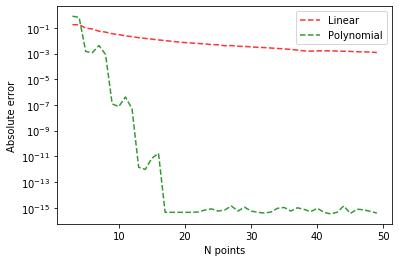

In [15]:
plt.plot(n_points, errors_lin_cheby, color='r', alpha=0.8, label='Linear', ls='--')
plt.plot(n_points, errors_poly_cheby, color='g', alpha=0.8, label='Polynomial', ls='--')
#plt.plot(n_points, error_theory, color='y', alpha=0.8, label='Theory', ls='--')
plt.xlabel('N points')
plt.ylabel('Absolute error')
plt.yscale('log')
plt.legend();

## 2D interpolation

In [16]:
def f_2d(x, y):
    return np.cos(0.5 * np.pi * x) * np.sin(0.5 * np.pi * y)

### Configuration

In [17]:
Ninterpx = 25
Ninterpy = 25
xinterp = gridpoints(Ninterpx)
yinterp = gridpoints(Ninterpy)

### Offline interpolation

In [18]:
def offline_interp_x(xinterp, yinterp, use_aaa=True):
    """Polynomials describe value at y for each constants x_i"""
    Ninterpy = len(yinterp)
    polynomials = []

    for i, x in enumerate(xinterp):
        values_y = np.zeros((Ninterpy))
        for j, y in enumerate(yinterp):
            values_y[j] = f_2d(x, y)

        if use_aaa:
            polynomial = aaa(yinterp, values_y, mmax=10)
        else:
            polynomial = BarycentricInterpolator(yinterp, values_y)
        polynomials.append(polynomial)  # x = x_i
    
    return polynomials

### Online interpolation and evaluation

In [19]:
def f_2d_interp_poly_aaa(x, y, polynomials, xinterp):
    x_values = [polynomial(y) for polynomial in polynomials]  # Determine the value at (x_i, y)
    x_polynomial = aaa(xinterp, x_values, mmax=10)  # Interpolate x_i values
    value = x_polynomial(x)
    return value

In [20]:
def evaluate_interp_2d_poly_aaa(x_eval, y_eval, f_true, f_interp, polynomials, xinterp):
    z_true = np.array([f_true(x, y) for x in x_eval for y in y_eval])
    z_interp = np.array([f_interp(x, y, polynomials, xinterp) for x in x_eval for y in y_eval])
    z_error = np.abs(z_interp - z_true)
    return z_true.reshape(-1), z_interp.reshape(-1), z_error.reshape(-1)

In [21]:
# Generate train set
n_points = np.arange(5, 15) # Range of points to evaluate accuracy over

errors_lin_cheby, errors_cubic_cheby, errors_poly_cheby, errors_poly_cheby_aaa = [], [], [], []

for n in n_points:
    xinterp = gridpoints(n)
    yinterp = gridpoints(n)

    # Truth
    values = np.zeros((n, n))
    for i, x in enumerate(xinterp):
        for j, y in enumerate(yinterp):
            values[i][j] = f_2d(x, y)

    polynomials_aaa = offline_interp_x(xinterp, yinterp)
    polynomials = offline_interp_x(xinterp, yinterp, use_aaa=False)
    f_2d_interp = RegularGridInterpolator((xinterp, yinterp), values)
    # f_2d_interp_poly = aaa(xinterp, f_2d, mmax=10)

    # Evaluate performance
    x_eval = np.linspace(np.min(xinterp), np.max(xinterp), 50)
    y_eval = np.linspace(np.min(yinterp), np.max(yinterp), 3)

    _, _, y_error_lin_cheby = evaluate_interp_2d(x_eval, y_eval, f_2d, f_2d_interp)
    _, _, y_error_poly_cheby_aaa = evaluate_interp_2d_poly_aaa(x_eval, y_eval, f_2d, f_2d_interp_poly_aaa,
                                                           polynomials_aaa, xinterp)
    _, _, y_error_poly_cheby = evaluate_interp_2d_poly_aaa(x_eval, y_eval, f_2d, f_2d_interp_poly_aaa,
                                                           polynomials, xinterp)

    errors_lin_cheby.append(np.max(np.abs(y_error_lin_cheby)))
    errors_poly_cheby_aaa.append(np.max(np.abs(y_error_poly_cheby_aaa)))
    errors_poly_cheby.append(np.max(np.abs(y_error_poly_cheby)))

R:\Projects\MultivariateInterpolation\baryrat.py:205: RuntimeWarning: divide by zero encountered in true_divide
  R[J] = N / D


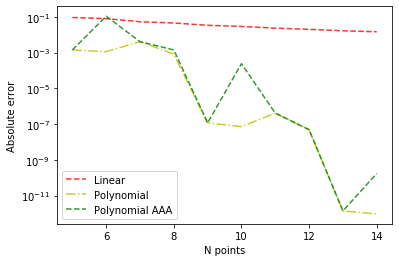

In [22]:
plt.plot(n_points, errors_lin_cheby, color='r', alpha=0.8, label='Linear', ls='--')
plt.plot(n_points, errors_poly_cheby, color='y', alpha=0.8, label='Polynomial', ls='-.')
plt.plot(n_points, errors_poly_cheby_aaa, color='g', alpha=0.8, label='Polynomial AAA', ls='--')
#plt.plot(n_points, error_theory, color='y', alpha=0.8, label='Theory', ls='--')
plt.xlabel('N points')
plt.ylabel('Absolute error')
plt.yscale('log')
plt.legend();

AAA interpolation seems to be less stable than Scipy BaryCentric interpolator.

# 3D interpolation (general ND)

In [23]:
def f_3d(x, y, z):
    #return np.cos(0.5 * np.pi * x) * np.sin(0.5 * np.pi * y) * np.sin(0.5 * np.pi * z)
    #return np.cos(0.5 * np.pi * x) * np.sin(0.5 * np.pi * y) * z
    return 100 * x + 10 *y + z

In [24]:
Ninterpx = 2
Ninterpy = 2
Ninterpz = 3
# xinterp = 2* gridpoints(Ninterpx)
# yinterp = gridpoints(Ninterpy)
# zinterp = 3*gridpoints(Ninterpz)
xinterp = np.linspace(0, Ninterpx - 1, Ninterpx)
yinterp = np.linspace(0, Ninterpy - 1, Ninterpy)
zinterp = np.linspace(0, Ninterpz - 1, Ninterpz)

grids = (xinterp, yinterp, zinterp)

In [25]:
# Compute values at tensor points
def ndm(*args):
    return np.array([x[(None,)*i + (slice(None),) + (None,)*(len(args)-i-1)] for i, x in enumerate(args)])

def compute_chebyshev_tensor(grids, f):
    """Compute Chebyshev tensor points and evaluated values"""
    points = np.array(ndm(*grids))
    values = f(*ndm(*grids))
    return points, values

In [26]:
# Compute the points of grid (points) and value of function at points (values)
points, values = compute_chebyshev_tensor(grids, f_3d)
values

array([[[  0.,   1.,   2.],
        [ 10.,  11.,  12.]],

       [[100., 101., 102.],
        [110., 111., 112.]]])

In [27]:
values.shape

(2, 2, 3)

In [28]:
def offline_polynomial_tensor(grids, values):
    """Compute polynomial tensor, dimensions D - 1"""
    value_col = values.reshape(-1, len(grids[-1]))
    poly = []
    for value in value_col:
        poly.append(BarycentricInterpolator(grids[-1], value))
    poly = np.array(poly).reshape(values.shape[:-1])
    return poly

In [29]:
# Generate offline polynomial tensor, the dimension is one smaller than the value tensor
poly = offline_polynomial_tensor(grids, values)
grid_current = grids[:-1]
poly.shape

(2, 2)

### Evaluation

In [30]:
Ninterpx = 2
Ninterpy = 2
Ninterpz = 3
# Evaluation grid
xinterp = np.linspace(0, Ninterpx - 1, Ninterpx)
yinterp = np.linspace(0, Ninterpy - 1, Ninterpy)
zinterp = np.linspace(0, Ninterpz - 1, Ninterpz)

eval_tensor = (xinterp, yinterp, zinterp)
eval_tensor2 = np.array(np.meshgrid(*eval_tensor))

In [31]:
eval_col = np.array(eval_tensor2).T.reshape(-1, eval_tensor2.shape[0])
eval_col

array([[0., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 1., 0.],
       [0., 0., 1.],
       [0., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.],
       [0., 0., 2.],
       [0., 1., 2.],
       [1., 0., 2.],
       [1., 1., 2.]])

In [32]:
eval_vector = eval_col[0]  # Debugging - pick first evaluation example (0, 0, 0)

# Get current point (z) and reduced grid (2d)
eval_point = eval_vector[-1]
eval_vector = eval_vector[:-1]

# Linearise polynomials, compute interpolation, reshape to grid for interpolation
poly_col = poly.reshape(-1)
value_point = np.array([p(eval_point) for p in poly_col])
value_point = value_point.reshape(poly.shape)

poly_current = []
for value in value_point:
    poly_current.append(BarycentricInterpolator(grid_current[-1], value))
poly_current = np.array(poly_current).reshape(grid_current[-1].shape)
grid_current = grid_current[:-1]
poly_current.shape

(2,)

In [33]:
# 2nd iteration
if eval_vector.shape[0] == 1:  # terminate
    eval_point = eval_vector
else:
    eval_point = eval_vector[-1]
    eval_vector = eval_vector[:-1]
    
shape_current = np.array(grid_current).shape

# Linearise polynomials, compute interpolation, reshape to grid for interpolation
poly_col = poly_current.reshape(-1)
value_point = np.array([p(eval_point) for p in poly_col])
value_point = value_point.reshape(-1, poly_current.shape[-1])



In [34]:

poly_current = []
for value in value_point:
    poly_current.append(BarycentricInterpolator(grid_current[-1], value))
if len(grid_current) > 1:
    poly_current = np.array(poly_current).reshape(grid_current[-1].shape)
#grid_current = grid_current[:-1]
#poly_current.shape

In [35]:
# 3rd iteration
if eval_vector.shape[0] == 1:  # terminate
    eval_point = eval_vector
    value = poly_current[0](eval_point)  # Final value
    
value

array([0.])

# 3D interpolation (general ND)

In [68]:
def f_3d_cos(x, y, z):
    return np.cos(0.5 * np.pi * x) * np.sin(0.5 * np.pi * y) * np.sin(0.5 * np.pi * z)

In [36]:
def interpolate_chebshev_tensor_nd(poly, grid, eval_vector_orig):
    """Computes intepolation for a general N-dimensional Chebyshev grid
    
    TODO: USE NDITER https://numpy.org/doc/stable/reference/arrays.nditer.html
    """
    
    # Get current point (z) and reduced grid (2d)
    eval_point = eval_vector_orig[-1]
    eval_vector = eval_vector_orig[:-1]
    grid_current = grid
    poly_current = poly

    dimensions = len(eval_vector)

    for d in range(dimensions):

        # Linearise polynomials, compute interpolation, reshape to grid for interpolation
        poly_col = poly_current.reshape(-1)

        value_point = np.array([p(eval_point) for p in poly_col]).reshape(poly_current.shape)
        if d < dimensions - 1:
            value_point = value_point.reshape(poly_current.shape)
        else:
            value_point = value_point.reshape(-1, poly_current.shape[-1])

        poly_current = []
        for value in value_point:
            poly_current.append(BarycentricInterpolator(grid_current[-1], value))
        if len(grid_current) > 1:
            poly_current = np.array(poly_current).reshape(grid_current[-1].shape)
        grid_current = grid_current[:-1]

        # 2nd iteration
        if eval_vector.shape[0] == 1:  # terminate
            eval_point = eval_vector
            value = poly_current[0](eval_point)[0]  # Final value
        else:
            eval_point = eval_vector[-1]
            eval_vector = eval_vector[:-1]

    return value

## Configuration

In [63]:
Ninterpx = 11
Ninterpy = 11
Ninterpz = 11
xinterp = np.linspace(-1, 1, Ninterpx)
yinterp = np.linspace(-1, 1, Ninterpy)
zinterp = np.linspace(-1, 1, Ninterpz)
xinterp = gridpoints(Ninterpx)
yinterp = gridpoints(Ninterpy)
zinterp = gridpoints(Ninterpz)
    
grids = (xinterp, yinterp, zinterp)
points, values = compute_chebyshev_tensor(grids, f_3d)

# Generate offline polynomial tensor, the dimension is one smaller than the value tensor
poly = offline_polynomial_tensor(grids, values)
grid_current = grids[:-1]

### Evaluation

In [64]:
Nevalx = 10
Nevaly = 10
Nevalz = 3
# Evaluation grid
x_eval = np.linspace(-0.9, 0.9, Nevalx)
y_eval = np.linspace(-0.9, 0.9, Nevaly)
z_eval = np.linspace(-0.9, 0.9, Nevalz)
#x_eval = np.linspace(-0.6, 0.6, 2)
#y_eval = np.linspace(-0.6, 0.6, 2)
#z_eval = np.linspace(-0.6, 0.6, 2)

eval_tensor = (xinterp, yinterp, zinterp)
eval_tensor2 = np.array(np.meshgrid(*eval_tensor))
eval_col = np.array(eval_tensor2).T.reshape(-1, eval_tensor2.shape[0])

In [65]:
with Timer() as t:
    value = interpolate_chebshev_tensor_nd(poly, grid_current, eval_col[0])

Time elapsed = 8.447 ms


### Measure errors

In [71]:
# Generate train set
n_points = np.arange(3, 21) # Range of points to evaluate accuracy over
errors_lin_cheby, errors_cubic_cheby, errors_poly_cheby, errors_poly_cheby_aaa = [], [], [], []

# Interpolation function
f = f_3d
f = f_3d_cos

for n in n_points:
    xinterp = gridpoints(n)
    yinterp = gridpoints(n)
    zinterp = gridpoints(n)
            
    grids = (xinterp, yinterp, zinterp)
    points, values = compute_chebyshev_tensor(grids, f)

    # Generate offline polynomial tensor, the dimension is one smaller than the value tensor
    poly = offline_polynomial_tensor(grids, values)
    grid_current = grids[:-1]
            
    # Evaluate performance
    Ninterpx = 5
    Ninterpy = 5
    Ninterpz = 3
    
    # Evaluate performance
    x_eval = np.linspace(np.min(xinterp), np.max(xinterp), Ninterpx)
    y_eval = np.linspace(np.min(yinterp), np.max(yinterp), Ninterpy)
    z_eval = np.linspace(np.min(zinterp), np.max(zinterp), Ninterpz)

    eval_tensor = (x_eval, y_eval, z_eval)
    eval_tensor2 = np.array(np.meshgrid(*eval_tensor))
    eval_col = np.array(eval_tensor2).T.reshape(-1, eval_tensor2.shape[0])

    values = np.array([interpolate_chebshev_tensor_nd(poly, grid_current, eval_vector) for eval_vector in eval_col])
    values_true = np.array([f(*eval_vector) for eval_vector in eval_col])

    errors_poly_cheby.append(np.max(np.abs(values - values_true)))

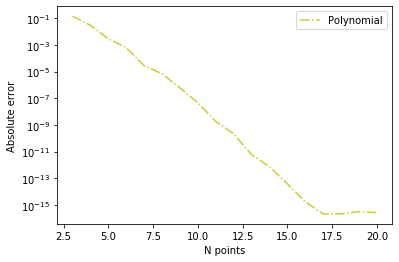

In [72]:
#plt.plot(n_points, errors_lin_cheby, color='r', alpha=0.8, label='Linear', ls='--')
plt.plot(n_points, errors_poly_cheby, color='y', alpha=0.8, label='Polynomial', ls='-.')
#plt.plot(n_points, errors_poly_cheby_aaa, color='g', alpha=0.8, label='Polynomial AAA', ls='--')
#plt.plot(n_points, error_theory, color='y', alpha=0.8, label='Theory', ls='--')
plt.xlabel('N points')
plt.ylabel('Absolute error')
plt.yscale('log')
plt.legend();

# 4D interpolation (general ND)

In [74]:
def f_4d_cos(x, y, z, w):
    return np.cos(0.5 * np.pi * x) * np.sin(0.5 * np.pi * y) * np.sin(0.5 * np.pi * z) * np.cos(0.5 * np.pi * w)

In [77]:
# Generate train set
n_points = np.arange(3, 5) # Range of points to evaluate accuracy over
errors_lin_cheby, errors_cubic_cheby, errors_poly_cheby, errors_poly_cheby_aaa = [], [], [], []

# Interpolation function
f = f_4d_cos

for n in n_points:
    xinterp = gridpoints(n)
    yinterp = gridpoints(n)
    zinterp = gridpoints(n)
    winterp = gridpoints(n)
            
    grids = (xinterp, yinterp, zinterp, winterp)
    points, values = compute_chebyshev_tensor(grids, f)

    # Generate offline polynomial tensor, the dimension is one smaller than the value tensor
    poly = offline_polynomial_tensor(grids, values)
    grid_current = grids[:-1]
            
    # Evaluate performance
    Ninterpx = 5
    Ninterpy = 5
    Ninterpz = 3
    Ninterpw = 3
    
    # Evaluate performance
    x_eval = np.linspace(np.min(xinterp), np.max(xinterp), Ninterpx)
    y_eval = np.linspace(np.min(yinterp), np.max(yinterp), Ninterpy)
    z_eval = np.linspace(np.min(zinterp), np.max(zinterp), Ninterpz)
    w_eval = np.linspace(np.min(winterp), np.max(winterp), Ninterpw)

    eval_tensor = (x_eval, y_eval, z_eval, w_eval)
    eval_tensor2 = np.array(np.meshgrid(*eval_tensor))
    eval_col = np.array(eval_tensor2).T.reshape(-1, eval_tensor2.shape[0])

    values = np.array([interpolate_chebshev_tensor_nd(poly, grid_current, eval_vector) for eval_vector in eval_col])
    values_true = np.array([f(*eval_vector) for eval_vector in eval_col])

    errors_poly_cheby.append(np.max(np.abs(values - values_true)))

ValueError: cannot reshape array of size 9 into shape (3,)

In [44]:
#plt.plot(n_points, errors_lin_cheby, color='r', alpha=0.8, label='Linear', ls='--')
plt.plot(n_points, errors_poly_cheby, color='y', alpha=0.8, label='Polynomial', ls='-.')
#plt.plot(n_points, errors_poly_cheby_aaa, color='g', alpha=0.8, label='Polynomial AAA', ls='--')
#plt.plot(n_points, error_theory, color='y', alpha=0.8, label='Theory', ls='--')
plt.xlabel('N points')
plt.ylabel('Absolute error')
plt.yscale('log')
plt.legend();

array([  0.,  10.,  20.,  30.,  40., 100., 110., 120., 130., 140., 200.,
       210., 220., 230., 240., 300., 310., 320., 330., 340., 400., 410.,
       420., 430., 440.,   1.,  11.,  21.,  31.,  41., 101., 111., 121.,
       131., 141., 201., 211., 221., 231., 241., 301., 311., 321., 331.,
       341., 401., 411., 421., 431., 441.,   2.,  12.,  22.,  32.,  42.,
       102., 112., 122., 132., 142., 202., 212., 222., 232., 242., 302.,
       312., 322., 332., 342., 402., 412., 422., 432., 442.,   3.,  13.,
        23.,  33.,  43., 103., 113., 123., 133., 143., 203., 213., 223.,
       233., 243., 303., 313., 323., 333., 343., 403., 413., 423., 433.,
       443.,   4.,  14.,  24.,  34.,  44., 104., 114., 124., 134., 144.,
       204., 214., 224., 234., 244., 304., 314., 324., 334., 344., 404.,
       414., 424., 434., 444.])

In [45]:
# TODO: USE NDITER https://numpy.org/doc/stable/reference/arrays.nditer.html
a = np.arange(6).reshape(2,3)
for x in np.nditer(a):
    print(x, end=' ')


0 1 2 3 4 5 

In [46]:

_, _, y_error_poly_cheby_aaa = evaluate_interp_2d_poly_aaa(x_eval, y_eval, f_2d, f_2d_interp_poly_aaa,
                                                           polynomials_aaa, xinterp)

IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
def f_2d_interp_poly_aaa(x, y, polynomials, xinterp):
    x_values = [polynomial(y) for polynomial in polynomials]  # Determine the value at (x_i, y)
    x_polynomial = aaa(xinterp, x_values, mmax=10)  # Interpolate x_i values
    value = x_polynomial(x)
    return value

In [ ]:
def evaluate_interp_2d_poly_aaa(x_eval, y_eval, f_true, f_2d_interp_poly_aaa, polynomials, xinterp):

    z_interp = np.array([f_2d_interp_poly_aaa(x, y, polynomials, xinterp) for x in x_eval for y in y_eval])

    return z_interp.reshape(-1)

In [ ]:
def compute_chebyshev_tensor(grid_dimensions, f):

    dim = len(grid_dimensions)
    grids = [gridpoints(d) for d in grid_dimensions]

    #points = np.zeros(len(grids))
    # Compute grid tensor points and their correponding indices
    points = np.array(np.meshgrid(*grids, indexing='ij'))
    values = np.zeros(points.shape[1:])
    points = points.T.reshape(-1, dim)

    grid_indices = [np.arange(len(grid)) for i, grid in enumerate(grids)]
    indices = np.array(np.meshgrid(*grid_indices, indexing='ij'))
    indices = indices.T.reshape(-1, dim)
    
    for point, index in zip(points, indices):
        x = point
        value = f(*point) 
        values[tuple(index)] = value
        #print(index, point, value, values[index])
    
    return values#, x, index
# x0, y0, z0
# x1, y0, z0
# x0, y1, z0
# x1, y1, z0

# x0, y0, z1
# x1, y0, z1
# x0, y1, z1
# x1, y1, z1

#for point in points:
# point = points[]

# NEED TO DETERMINE THE INDEX OF 

In [ ]:
grid_dimensions = (Ninterpx, Ninterpy, Ninterpz)

tensor = compute_chebyshev_tensor(grid_dimensions, f_3d)

In [ ]:
tensor

In [ ]:
def func2(x, y, z):
    return np.sin(y * x)+z
result3 = f_3d(x2,y2,z2)

In [ ]:
x2,y2  = ndm(xaxis,yaxis)

result3 = f_2d(x2,y2)
result3.shape

In [ ]:
def scan_dimension(grids, f):
    if grids.shape[0] == 1:
        
    else:
        scan_dimension(grids)
    return values

In [ ]:
def offline_interp_x(grids, use_aaa=True):
    """Polynomials describe value at y for each constants x_i"""
    Ninterpy = len(yinterp)
    polynomials = []
    d = grids.shape[0]

    
    
    points = np.meshgrid(grids)
    
    for i in grids.shape[0]:
    
    
    for i, x in enumerate(grids[0]):
        values_y = np.zeros((Ninterpy))
        for j, y in enumerate(yinterp):
            values_y[j] = f_2d(x, y)

        if use_aaa:
            polynomial = aaa(yinterp, values_y, mmax=10)
        else:
            polynomial = BarycentricInterpolator(yinterp, values_y)
        polynomials.append(polynomial)  # x = x_i
    
    return polynomials